# Optimal sampling

The code aims to find the "best" way to sample a Digital Elevation Model (DEM) for interpolation.  It does this by repeatedly generating random sets of sample points, interpolating the DEM based on those points, and calculating the Mean Squared Error (MSE) between the interpolated DEM and the original DEM.  The sampling strategy that produces the lowest MSE is considered the best.

Here's a breakdown of the key parts:

0. **Import the necessary libraries**

In [1]:
# Import libraries
import numpy as np  # perform numerical operations, particularly for arrays.
import rasterio  # read and write geospatial raster data (like GeoTIFFs).
import matplotlib.pyplot as plt  # create plots and visualizations.
from ipywidgets import interact # create interactive controls (like sliders, dropdowns, etc.)
from scipy import interpolate # interpolate spatially
import rasterio  # Import the rasterio library for reading and writing geospatial raster data (like GeoTIFFs).

1. **Load the DEM Raster**  

In [2]:
# Open the Digital Elevation Model (DEM) raster file
raster = rasterio.open('datos/dem.tif')

# Read the first band of the DEM (assuming it's a single-band raster)
dem = raster.read(1)  # Extracts a 2D array representing elevation values

# Get the number of rows and columns in the DEM
n_rows, n_cols = dem.shape

2. **Random Sampling:** The code generates random row and column indices within the DEM to select sample points.  The np.random.seed(i) ensures that each run uses a different set of random points, but the results are reproducible if you run the code again with the same parameters. Adding the corners to the sample points ensures that the edge of the DEM is well represented.

In [3]:
n_points = 10 # number of samples that we can take on the field

# Generate random row and column indices within the DEM dimensions
np.random.seed(49)
rows = np.random.randint(0, n_rows, n_points)  # Random row indices
cols = np.random.randint(0, n_cols, n_points)  # Random column indices
rows = np.append(rows,[0,0,n_rows-1,n_rows-1])
cols = np.append(cols,[0,n_cols-1,0,n_cols-1])
# Extract elevation values at the randomly selected points
elevations = dem[rows, cols]

3. **Interpolation:**  interpolate.griddata uses cubic interpolation to estimate the elevation values at all points on the DEM grid, based on the sampled points. Cubic interpolation creates a smoother surface compared to other methods.

In [4]:
grid_x, grid_y = np.meshgrid(np.arange(0, n_rows), np.arange(0, n_cols), indexing='ij')
grid_z = interpolate.griddata(np.column_stack([rows, cols]), elevations, (grid_x, grid_y), method= 'cubic')

4. **Mean Absolute Error (MAE):** The MAE measures the average absolute difference between the original DEM and the interpolated DEM.  A lower MAE indicates a better interpolation.

In [5]:
MAE = np.nanmean((np.abs(dem-grid_z)))

5. **Visualization:** The code generates plots to visualize the results:

- The original DEM with the sampled points overlaid.
- Histograms comparing the distribution of sampled elevations to the original DEM's elevations.
- The interpolated DEM.
- The difference between the original and interpolated DEMs, which helps to see where the interpolation is most accurate and least accurate.

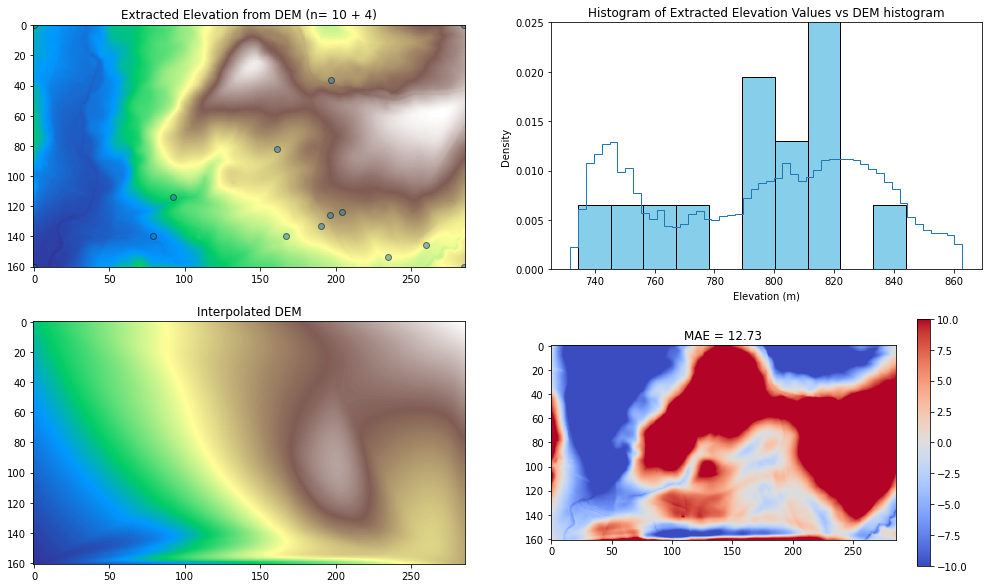

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Plot the DEM with the extracted points
axes[0,0].imshow(dem, cmap='terrain')
axes[0,0].scatter(cols, rows, edgecolor='k',alpha = 0.5)
axes[0,0].set_title('Extracted Elevation from DEM (n= '+str(n_points)+' + 4)')

# Plot histogram of the extracted elevation values
axes[0,1].hist(elevations, bins=10, color='skyblue', edgecolor='black', density = True)
axes[0,1].hist(dem.flatten(),bins = 50,histtype='step', density = True, label = 'DEM')
axes[0,1].set_xlabel('Elevation (m)')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Histogram of Extracted Elevation Values vs DEM histogram')
axes[0,1].set_ylim([0,0.025])

axes[1,0].imshow(grid_z, cmap='terrain')
axes[1,0].set_title('Interpolated DEM')
#axes[1,0].scatter(col_coords, row_coords, edgecolor='k',alpha = 0.5)
plot4 = axes[1,1].imshow(dem-grid_z, cmap='coolwarm',vmin=-10,vmax=10)
axes[1,1].set_title(f'MAE = {MAE:.2f}') 
plt.colorbar(plot4)
plt.show()  # Display the plots

## Can we reduce the number of samples and still obtain a good interpolation?
6. **Optimization:** The code iterates through multiple random sampling strategies and keeps track of the one that yields the lowest MSE.  This is a basic form of optimization – trying to find the best solution among many possibilities.

7. **Interactivity:** ipywidgets.interact creates a slider that allows the user to control the number of iterations (n_runs).  This makes it easy to experiment and see how different numbers of random samples affect the results.

In essence, this code explores different ways to sparsely sample a DEM and then reconstruct the full DEM from those samples.  The goal is to find a sampling strategy that minimizes the error in the reconstruction.  While the code uses a random search approach, more sophisticated optimization algorithms could be used to find even better sampling strategies.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from ipywidgets import interact

def optimal_sampling(n_runs):
    """
    Search for an optimal sampling strategy to interpolate a DEM.
    Displays:
    1. The DEM with sampled elevation points.
    2. The histograms of the sampled elevation values vs the original DEM.
    3. The interpolated DEM.
    4. The difference between the original DEM and the interpolated DEM.

    Parameters:
    - n_runs (int): Number of iterations to search for an optimal sampling strategy.
    """
    MAE_optimal = np.inf  # Initialize the minimum Mean Squared Error.
    
    for i in range(n_runs):
        np.random.seed(i)  # Ensure reproducibility for each iteration.
        
        # Generate random sample points within DEM dimensions
        rows = np.random.randint(0, n_rows, n_points)
        cols = np.random.randint(0, n_cols, n_points)
        
        # Add corner points to ensure interpolation stability
        rows = np.append(rows, [0, 0, n_rows-1, n_rows-1])
        cols = np.append(cols, [0, n_cols-1, 0, n_cols-1])
        
        # Extract elevation values from the DEM
        elevations = dem[rows, cols]
        
        # Create a meshgrid for interpolation
        grid_x, grid_y = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')
        
        # Perform cubic interpolation
        grid_z = interpolate.griddata(np.column_stack([rows, cols]), elevations, (grid_x, grid_y), method='cubic')
        
        # Compute Absolute Squared Error (MAE)
        MAE = np.nanmean((np.abs(dem - grid_z)))
        
        # Store the best (lowest MSE) interpolation result
        if MAE < MAE_optimal:
            rows_optimal = rows
            cols_optimal = cols
            MAE_optimal = MAE
            grid_z_optimal = grid_z
            elevations_optimal = elevations
            i_optimal = i
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(17, 10))
    
    # Original DEM with sampled points
    axes[0, 0].imshow(dem, cmap='terrain')
    axes[0, 0].scatter(cols_optimal, rows_optimal, edgecolor='k', alpha=0.5)
    axes[0, 0].set_title(f'Extracted Elevation from DEM (n={n_points})')
    
    # Histogram comparison
    axes[0, 1].hist(elevations_optimal, bins=10, color='skyblue', edgecolor='black', density=True, label='Sampled')
    axes[0, 1].hist(dem.flatten(), bins=50, histtype='step', density=True, label='DEM')
    axes[0, 1].set_xlabel('Elevation (m)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Histogram: Sampled vs DEM')
    axes[0, 1].legend()
    axes[0, 1].set_ylim([0,0.025])
    
    # Interpolated DEM
    axes[1, 0].imshow(grid_z_optimal, cmap='terrain')
    axes[1, 0].set_title('Interpolated DEM')
    
    # Difference map
    im = axes[1, 1].imshow(dem - grid_z_optimal, cmap='coolwarm', vmin=-10, vmax=10)
    axes[1, 1].set_title(f'Difference Map (MAE = {MAE_optimal:.2f})')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"The optimal solution was obtained in the iteration i = {i_optimal}")

# Create an interactive widget to select the number of iterations
interact(optimal_sampling, n_runs=[1, 10, 50, 100, 500, 1000, 5000])


interactive(children=(Dropdown(description='n_runs', options=(1, 10, 50, 100, 500, 1000, 5000), value=1), Outp…

<function __main__.optimal_sampling(n_runs)>

## What about a regular gridded sampling approach?

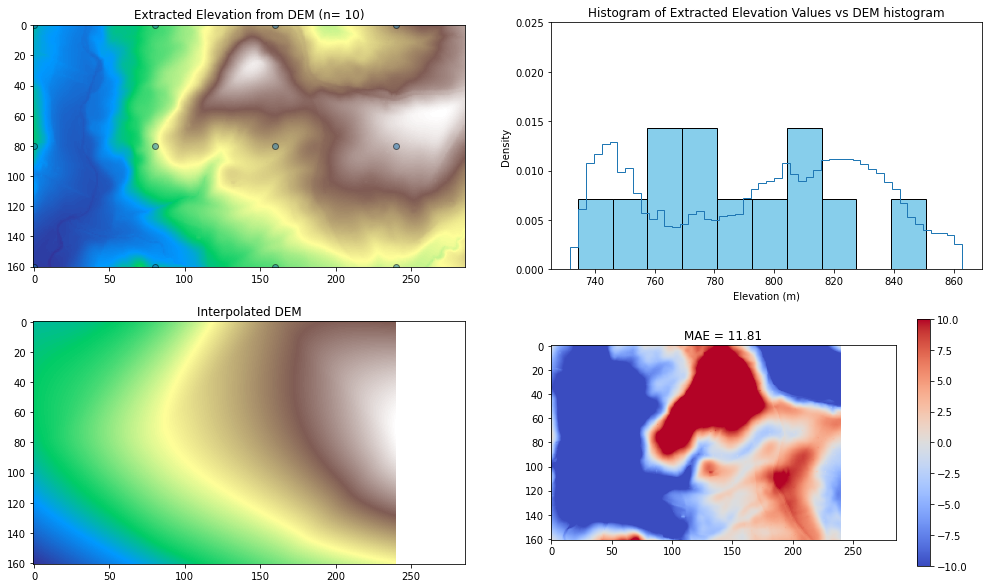

In [8]:
# Compute number of points per axis (square root approximation)
num_points_per_axis = int(np.sqrt(n_points))

# Ensure spacing is equal for both rows and columns
spacing = min(n_rows // (num_points_per_axis - 1), n_cols // (num_points_per_axis - 1))

# Compute number of points per axis (square root approximation)
num_points_per_axis = int(np.sqrt(n_points))

# Ensure spacing is equal for both rows and columns
spacing = min(n_rows // (num_points_per_axis - 1), n_cols // (num_points_per_axis - 1))

rows, cols = np.meshgrid(np.arange(0, n_rows,spacing), np.arange(0, n_cols,spacing), indexing='ij')
rows = rows.flatten()
cols = cols.flatten()

elevations = dem[rows, cols]

grid_z = interpolate.griddata(np.column_stack([rows, cols]), elevations, (grid_x, grid_y), method= 'cubic')

MAE = np.nanmean((np.abs(dem-grid_z)))

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Plot the DEM with the extracted points
axes[0,0].imshow(dem, cmap='terrain')
axes[0,0].scatter(cols, rows, edgecolor='k',alpha = 0.5)
axes[0,0].set_title(f'Extracted Elevation from DEM (n= {n_points})')

# Plot histogram of the extracted elevation values
axes[0,1].hist(elevations, bins=10, color='skyblue', edgecolor='black', density = True)
axes[0,1].hist(dem.flatten(),bins = 50,histtype='step', density = True, label = 'DEM')
axes[0,1].set_xlabel('Elevation (m)')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Histogram of Extracted Elevation Values vs DEM histogram')
axes[0,1].set_ylim([0,0.025])

axes[1,0].imshow(grid_z, cmap='terrain')
axes[1,0].set_title('Interpolated DEM')
#axes[1,0].scatter(col_coords, row_coords, edgecolor='k',alpha = 0.5)
plot4 = axes[1,1].imshow(dem-grid_z, cmap='coolwarm',vmin=-10,vmax=10)
axes[1,1].set_title(f'MAE = {MAE:.2f}') 
plt.colorbar(plot4)
plt.show()  # Display the plots